In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd 
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
from ADD_GCN import DynamicGraphConvolution,ADD_GCN
matplotlib.style.use('ggplot')
#忽略警告
import warnings
warnings.filterwarnings("ignore")
path='D:\ML_data_sql\Multi_Label_dataset\\train.csv'

In [ ]:
#dataset
#可以resize 400*400
#0.85 训练 0.15 验证
#make dataset
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['Id']
        self.all_labels = np.array(self.csv.drop(['Id','Genre'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            #make data argumentaion
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                #p=0.5 to horizontal turn over 
                transforms.RandomHorizontalFlip(p=0.5),
                #（-45，45） angle to revolve
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])

        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            #[:10] to predict and show the effect 
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])

            # define the validation transforms  resize 400*400
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])

        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])

             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"D:\\ML_data_sql\\Multi_Label_dataset\\Images\\{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }


In [ ]:
from torchvision import models as models
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 25 classes in total
    model.fc = nn.Linear(2048, 25)
    return model

#model 2 
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 400, 400]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 400, 400]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 200,200]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 200,200]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 100, 100]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 50, 50]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 25, 25]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 25, 25]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),       # [512, 13, 13]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*13*13, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 25)
        )
        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

In [ ]:
from sklearn.metrics import average_precision_score,roc_auc_score
def compute_mAP(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)

def comput_roc(outputs,labels):
    y_true = labels.cpu().detach().numpy()
    y_pred = outputs.cpu().detach().numpy()
    ROC = []
    for i in range(y_true.shape[0]):
        ROC.append(roc_auc_score(y_true[i],y_pred[i]))
    return np.mean(ROC)

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [ ]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    train_running_mAP = 0.0
    train_running_ROC = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output1,output2 = model(data)
        
        #outputs = torch.sigmoid(outputs)
        outputs = (output1+output2)/2
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        train_running_mAP += compute_mAP(outputs,target)
        train_running_ROC += comput_roc(outputs,target)
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_mAP = train_running_mAP/counter
    train_ROC = train_running_ROC/counter
    print(f"Train mAP: {train_mAP:.4f}")
    print(f'Train ROC: {train_ROC:.4f}')
    return train_loss,train_mAP,train_ROC

In [ ]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    val_running_mAP = 0.0
    val_running_ROC = 0.0
    with torch.no_grad():
        model_result = []
        targets = []
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            # outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            output1,output2 = model(data)
            outputs = (output1+output2)/2
            #outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            model_result.extend(outputs.cpu().numpy())
            targets.extend(target.cpu().numpy())
            val_running_mAP += compute_mAP(outputs,target)
            val_running_ROC += comput_roc(outputs,target)
            val_running_loss += loss.item()
            
        result = calculate_metrics(np.array(model_result), np.array(targets))
        val_loss = val_running_loss / counter
        val_mAP = val_running_mAP/counter
        val_ROC = val_running_ROC/counter
        print("epoch:{:2d}  test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))
        print(f"Val mAP: {val_mAP:.4f}")
        print(f'Val ROC: {val_ROC:.4f}')
        return val_loss,val_mAP,val_ROC

In [8]:
#train
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model2 = model(pretrained=True, requires_grad=False).to(device)
premodel = models.resnet50(pretrained=True)
# premodel.eval()
model2 = ADD_GCN(premodel,25).to(device)
# learning parameters
lr = 0.0001
epochs = 20
batch_size = 2
optimizer = optim.Adam(model2.parameters(), lr=lr)
criterion = nn.MultiLabelSoftMarginLoss()
# read the training csv file
print('load data...')
train_csv = pd.read_csv('D:\ML_data_sql\Multi_Label_dataset\\train.csv')
# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)
print('loaded over')
train_loss = []
valid_loss = []
train_mAP = []
train_ROC = []
valid_mAP = []
valid_ROC = []
print('begin to train')
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss,train_epoch_mAP,train_epoch_ROC = train(
        model2, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss,val_epoch_mAP,val_epoch_ROC = validate(
        model2, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_mAP.append(train_epoch_mAP)
    train_ROC.append(train_epoch_ROC)
    valid_mAP.append(val_epoch_mAP)
    valid_ROC.append(val_epoch_ROC)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

load data...
Number of training images: 6165
Number of validation images: 1089
loaded over
begin to train
Epoch 1 of 20
Training


100%|██████████| 3082/3082 [09:12<00:00,  5.58it/s]


Train mAP: 0.5723
Train ROC: 0.8379
Validating


100%|██████████| 539/539 [00:31<00:00, 16.95it/s]


epoch: 0  test: micro f1: 0.167 macro f1: 0.041 samples f1: 0.130
Val mAP: 0.5195
Val ROC: 0.8342
Train Loss: 0.2548
Val Loss: 0.2468
Epoch 2 of 20
Training


100%|██████████| 3082/3082 [09:10<00:00,  5.60it/s]


Train mAP: 0.5800
Train ROC: 0.8432
Validating


100%|██████████| 539/539 [00:31<00:00, 16.93it/s]


epoch: 1  test: micro f1: 0.338 macro f1: 0.053 samples f1: 0.308
Val mAP: 0.5379
Val ROC: 0.8265
Train Loss: 0.2369
Val Loss: 0.2552
Epoch 3 of 20
Training


100%|██████████| 3082/3082 [09:07<00:00,  5.63it/s]


Train mAP: 0.5790
Train ROC: 0.8431
Validating


100%|██████████| 539/539 [00:31<00:00, 16.94it/s]


epoch: 2  test: micro f1: 0.223 macro f1: 0.035 samples f1: 0.193
Val mAP: 0.5012
Val ROC: 0.7905
Train Loss: 0.2375
Val Loss: 0.2609
Epoch 4 of 20
Training


100%|██████████| 3082/3082 [09:08<00:00,  5.62it/s]


Train mAP: 0.5741
Train ROC: 0.8429
Validating


100%|██████████| 539/539 [00:31<00:00, 16.96it/s]


epoch: 3  test: micro f1: 0.188 macro f1: 0.033 samples f1: 0.154
Val mAP: 0.5248
Val ROC: 0.8178
Train Loss: 0.2381
Val Loss: 0.2455
Epoch 5 of 20
Training


100%|██████████| 3082/3082 [09:07<00:00,  5.62it/s]


Train mAP: 0.5803
Train ROC: 0.8468
Validating


100%|██████████| 539/539 [00:31<00:00, 17.00it/s]


epoch: 4  test: micro f1: 0.200 macro f1: 0.036 samples f1: 0.166
Val mAP: 0.5327
Val ROC: 0.8240
Train Loss: 0.2366
Val Loss: 0.2427
Epoch 6 of 20
Training


100%|██████████| 3082/3082 [09:08<00:00,  5.62it/s]


Train mAP: 0.5870
Train ROC: 0.8493
Validating


100%|██████████| 539/539 [00:31<00:00, 16.99it/s]


epoch: 5  test: micro f1: 0.208 macro f1: 0.037 samples f1: 0.175
Val mAP: 0.5404
Val ROC: 0.8262
Train Loss: 0.2338
Val Loss: 0.2414
Epoch 7 of 20
Training


100%|██████████| 3082/3082 [09:07<00:00,  5.63it/s]


Train mAP: 0.5912
Train ROC: 0.8525
Validating


100%|██████████| 539/539 [00:31<00:00, 17.04it/s]


epoch: 6  test: micro f1: 0.152 macro f1: 0.036 samples f1: 0.126
Val mAP: 0.5476
Val ROC: 0.8356
Train Loss: 0.2320
Val Loss: 0.2362
Epoch 8 of 20
Training


100%|██████████| 3082/3082 [08:57<00:00,  5.73it/s]


Train mAP: 0.5909
Train ROC: 0.8538
Validating


100%|██████████| 539/539 [00:31<00:00, 17.28it/s]


epoch: 7  test: micro f1: 0.291 macro f1: 0.046 samples f1: 0.261
Val mAP: 0.5351
Val ROC: 0.8282
Train Loss: 0.2311
Val Loss: 0.2415
Epoch 9 of 20
Training


100%|██████████| 3082/3082 [08:56<00:00,  5.75it/s]


Train mAP: 0.5952
Train ROC: 0.8545
Validating


100%|██████████| 539/539 [00:31<00:00, 17.32it/s]


epoch: 8  test: micro f1: 0.277 macro f1: 0.059 samples f1: 0.229
Val mAP: 0.5463
Val ROC: 0.8328
Train Loss: 0.2299
Val Loss: 0.2512
Epoch 10 of 20
Training


100%|██████████| 3082/3082 [08:56<00:00,  5.74it/s]


Train mAP: 0.5982
Train ROC: 0.8563
Validating


100%|██████████| 539/539 [00:31<00:00, 17.29it/s]


epoch: 9  test: micro f1: 0.309 macro f1: 0.061 samples f1: 0.265
Val mAP: 0.5281
Val ROC: 0.8153
Train Loss: 0.2287
Val Loss: 0.2609
Epoch 11 of 20
Training


100%|██████████| 3082/3082 [08:57<00:00,  5.74it/s]


Train mAP: 0.6001
Train ROC: 0.8577
Validating


100%|██████████| 539/539 [00:31<00:00, 17.35it/s]


epoch:10  test: micro f1: 0.198 macro f1: 0.044 samples f1: 0.158
Val mAP: 0.5404
Val ROC: 0.8277
Train Loss: 0.2278
Val Loss: 0.2479
Epoch 12 of 20
Training


100%|██████████| 3082/3082 [09:00<00:00,  5.70it/s]


Train mAP: 0.6033
Train ROC: 0.8582
Validating


100%|██████████| 539/539 [00:31<00:00, 16.92it/s]


epoch:11  test: micro f1: 0.255 macro f1: 0.048 samples f1: 0.230
Val mAP: 0.5489
Val ROC: 0.8322
Train Loss: 0.2268
Val Loss: 0.2406
Epoch 13 of 20
Training


100%|██████████| 3082/3082 [09:02<00:00,  5.68it/s]


Train mAP: 0.6049
Train ROC: 0.8596
Validating


100%|██████████| 539/539 [00:31<00:00, 17.26it/s]


epoch:12  test: micro f1: 0.219 macro f1: 0.051 samples f1: 0.189
Val mAP: 0.5379
Val ROC: 0.8277
Train Loss: 0.2261
Val Loss: 0.2417
Epoch 14 of 20
Training


100%|██████████| 3082/3082 [09:03<00:00,  5.67it/s]


Train mAP: 0.6071
Train ROC: 0.8605
Validating


100%|██████████| 539/539 [00:31<00:00, 17.06it/s]


epoch:13  test: micro f1: 0.228 macro f1: 0.052 samples f1: 0.192
Val mAP: 0.5402
Val ROC: 0.8300
Train Loss: 0.2254
Val Loss: 0.2403
Epoch 15 of 20
Training


100%|██████████| 3082/3082 [08:58<00:00,  5.73it/s]


Train mAP: 0.6082
Train ROC: 0.8611
Validating


100%|██████████| 539/539 [00:31<00:00, 17.30it/s]


epoch:14  test: micro f1: 0.268 macro f1: 0.065 samples f1: 0.234
Val mAP: 0.5561
Val ROC: 0.8401
Train Loss: 0.2252
Val Loss: 0.2391
Epoch 16 of 20
Training


100%|██████████| 3082/3082 [09:00<00:00,  5.71it/s]


Train mAP: 0.6094
Train ROC: 0.8630
Validating


100%|██████████| 539/539 [00:31<00:00, 17.10it/s]


epoch:15  test: micro f1: 0.231 macro f1: 0.050 samples f1: 0.199
Val mAP: 0.5482
Val ROC: 0.8424
Train Loss: 0.2234
Val Loss: 0.2358
Epoch 17 of 20
Training


100%|██████████| 3082/3082 [08:50<00:00,  5.81it/s]


Train mAP: 0.6130
Train ROC: 0.8647
Validating


100%|██████████| 539/539 [00:30<00:00, 17.63it/s]


epoch:16  test: micro f1: 0.180 macro f1: 0.040 samples f1: 0.145
Val mAP: 0.5585
Val ROC: 0.8438
Train Loss: 0.2225
Val Loss: 0.2325
Epoch 18 of 20
Training


100%|██████████| 3082/3082 [08:49<00:00,  5.82it/s]


Train mAP: 0.6131
Train ROC: 0.8653
Validating


100%|██████████| 539/539 [00:30<00:00, 17.69it/s]


epoch:17  test: micro f1: 0.225 macro f1: 0.052 samples f1: 0.188
Val mAP: 0.5610
Val ROC: 0.8432
Train Loss: 0.2221
Val Loss: 0.2340
Epoch 19 of 20
Training


100%|██████████| 3082/3082 [08:50<00:00,  5.81it/s]


Train mAP: 0.6135
Train ROC: 0.8662
Validating


100%|██████████| 539/539 [00:30<00:00, 17.67it/s]


epoch:18  test: micro f1: 0.237 macro f1: 0.062 samples f1: 0.206
Val mAP: 0.5614
Val ROC: 0.8419
Train Loss: 0.2213
Val Loss: 0.2379
Epoch 20 of 20
Training


100%|██████████| 3082/3082 [08:50<00:00,  5.81it/s]


Train mAP: 0.6162
Train ROC: 0.8679
Validating


100%|██████████| 539/539 [00:30<00:00, 17.47it/s]

epoch:19  test: micro f1: 0.200 macro f1: 0.056 samples f1: 0.165
Val mAP: 0.5589
Val ROC: 0.8461
Train Loss: 0.2202
Val Loss: 0.2388


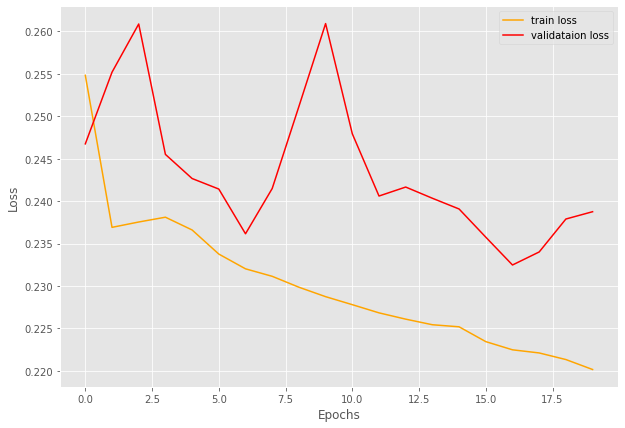

In [9]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './addgcn_multi_kaggle.pth')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./addgcn_loss_kaggle.png')
plt.show()

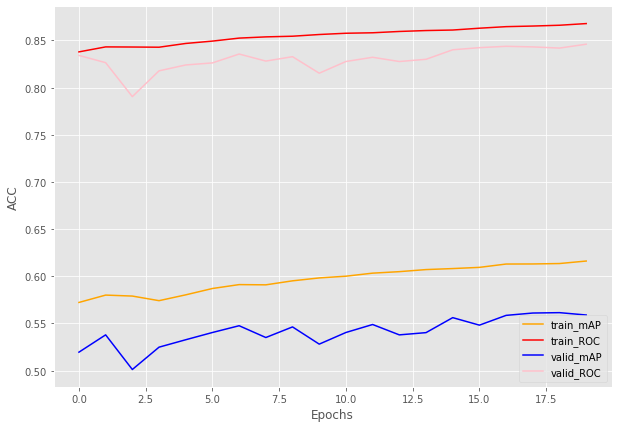

In [10]:
plt.figure(figsize=(10, 7))
plt.plot(train_mAP, color='orange', label='train_mAP')
plt.plot(train_ROC, color='red', label='train_ROC')
plt.plot(valid_mAP, color='blue',label ='valid_mAP')
plt.plot(valid_ROC, color='pink', label='valid_ROC')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.savefig('./addgcn_ACC_kaggle.png')
plt.show()

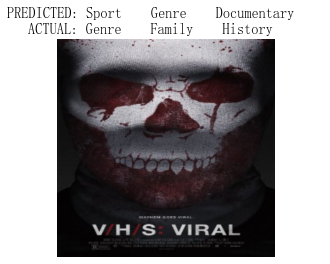

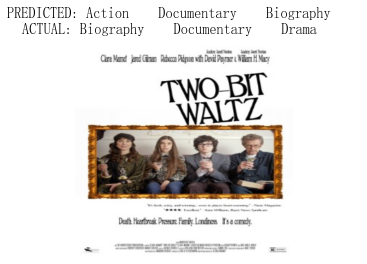

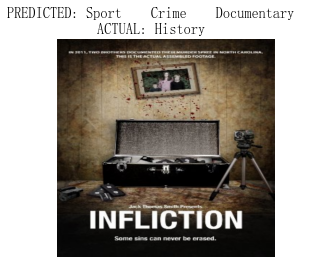

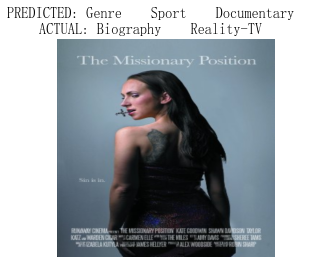

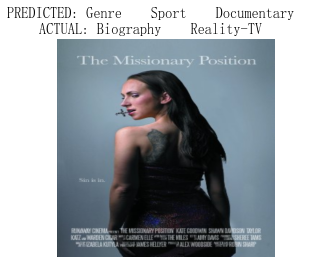

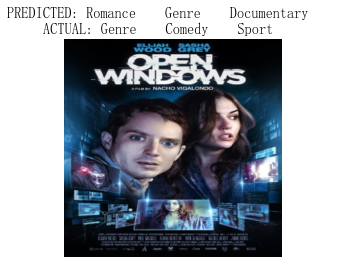

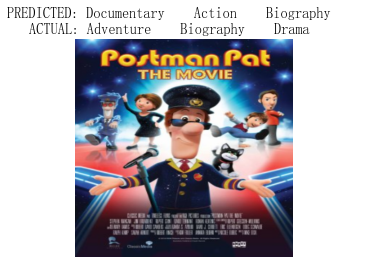

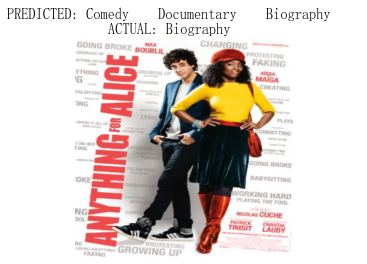

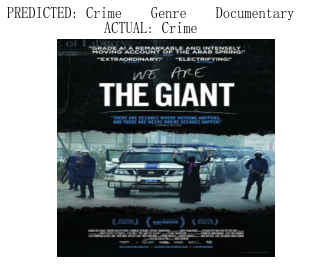

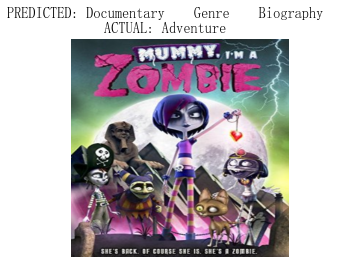

In [12]:
model2.eval()
import pylab as mpl
mpl.rcParams['font.sans-serif'] = ['FangSong']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False
train_csv = pd.read_csv('D:\ML_data_sql\Multi_Label_dataset\\train.csv')
genres = train_csv.columns.values[1:]
# prepare the test dataset and dataloader
test_data = ImageDataset(
    train_csv, train=False, test=True
)
test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=False
)
for counter, data in enumerate(test_loader):
    image, target = data['image'].to(device), data['label']
    # get all the index positions where value == 1
    target_indices = [i for i in range(len(target[0])) if target[0][i] == 1]
    # get the predictions by passing the image through the model
    output1,output2 = model2(image)
    outputs = (output1+output2)/2
    # outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-3:]
    string_predicted = ''
    string_actual = ''
    for i in range(len(best)):
        string_predicted += f"{genres[best[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{genres[target_indices[i]]}    "
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
    plt.savefig(f"./inference_kaggle_addgcn{counter}.jpg")
    plt.show()